# EXERCISE 1 - BINARY CLASSIFICATION TASK WITH RNN CLASSIFIERS (LSTM-GRU LAYERS)

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import tarfile
from sklearn.datasets import load_files

### WAYS OF LOADING THE FILES

In [2]:
# # # Download Data when in google Collab
# !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar xvzf aclImdb_v1.tar.gz > /dev/null && rm -rf aclImdb_v1.tar.gz # Extract contents and delete the zipped file

Load files when in collab:

In [3]:
# from sklearn.datasets import load_files

# # Load the files when in Google Collab
# movies_train = load_files(container_path="/content/aclImdb/train", encoding="utf-8")
# movies_test = load_files(container_path="/content/aclImdb/test", encoding="utf-8")




Load file when running local:

In [4]:
# from sklearn.datasets import load_files

# movies_train = load_files(container_path="../../../../../big_files_DS/aclImdb/train", encoding="utf-8")
# movies_test = load_files(container_path="../../../../../big_files_DS/aclImdb/test", encoding="utf-8")
# # print(type(movies_train))

Load files when in wsl:

In [5]:
from sklearn.datasets import load_files
movies_train = load_files(container_path="//home/aclImdb/train", encoding="utf-8")
movies_test = load_files(container_path="//home/aclImdb/test", encoding="utf-8")
# print(type(movies_train))

In [6]:
# Transform train dataset into a dataframe
data_train = {'reviews': movies_train.data, 'sentiment': movies_train.target}
df_train = pd.DataFrame(data_train)

# Transform test dataset into a dataframe
data_test = {'reviews': movies_test.data, 'sentiment': movies_test.target}
df_test = pd.DataFrame(data_test)

del movies_train, movies_test # free memory

print(df_train.iloc[:10])
print('----------------------------------------------------------------------------------------')
print(df_test.iloc[:10])

                                             reviews  sentiment
0  Full of (then) unknown actors TSF is a great b...          2
1  Amount of disappointment I am getting these da...          2
2  The future, we are told, are what we make of i...          2
3  Dan Katzir has produced a wonderful film that ...          1
4  If you want Scream or anything like the big-st...          1
5  Although its mold of 1949 appears somewhat mel...          2
6  Gloomy Sunday - Ein Lied von Liebe und Tod dir...          2
7  This movie was ridiculous. The plot is complet...          2
8  Why was this movie made? No doubt to sucker in...          2
9  Outlandish premise that rates low on plausibil...          0
----------------------------------------------------------------------------------------
                                             reviews  sentiment
0  Don't hate Heather Graham because she's beauti...          1
1  I don't know how this movie has received so ma...          0
2  I caught thi

### CLEAN OUR DATA

In [7]:
# Drop rows where 'sentiment' is 2 from train & test sets
df_train = df_train[df_train['sentiment'] != 2]
df_test = df_test[df_test['sentiment'] != 2]


df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

# Define the train dataset with 5000 rows by test set
df_train = pd.concat([df_train, df_test[:5000]])

print(f'The size of training set is: {len(df_train)}')
print(f'The size of test set is: {len(df_test[5000:])}')

The size of training set is: 30000
The size of test set is: 20000


In [8]:
from sklearn.utils import shuffle

# Shuffle dataframes because they are sorted.
df_train = shuffle(df_train)
df_train.reset_index(inplace=True, drop=True)
df_test = shuffle(df_test)
df_test.reset_index(inplace=True, drop=True)

df_train.head()

,reviews,sentiment
0,Pretty good film from Preminger; labyrinthine ...,1
1,This is one of the worse movies that I have ev...,0
2,Perfect cast for a few-person drama. Simon is ...,1
3,Film makeovers of old TV shows seems to be the...,0
4,"""Bedknobs and Broomsticks"" is a magical advent...",1


In [9]:
X_train = df_train.reviews
y_train = df_train.sentiment

In [10]:
# Split dev and test data
from sklearn.model_selection import train_test_split

X_dev, X_test, y_dev, y_test = train_test_split(df_test.reviews[5000:], df_test.sentiment[5000:], test_size=0.5, random_state=42)
print(f"Number of observations in dev set: {X_dev.shape[0]}")
print(f"Number of observations in test set: {X_test.shape[0]}")

Number of observations in dev set: 10000
Number of observations in test set: 10000


### PLOT THE SIZE OF THE LABELS (POSITIVE/NEGATIVE) FOR EACH SET

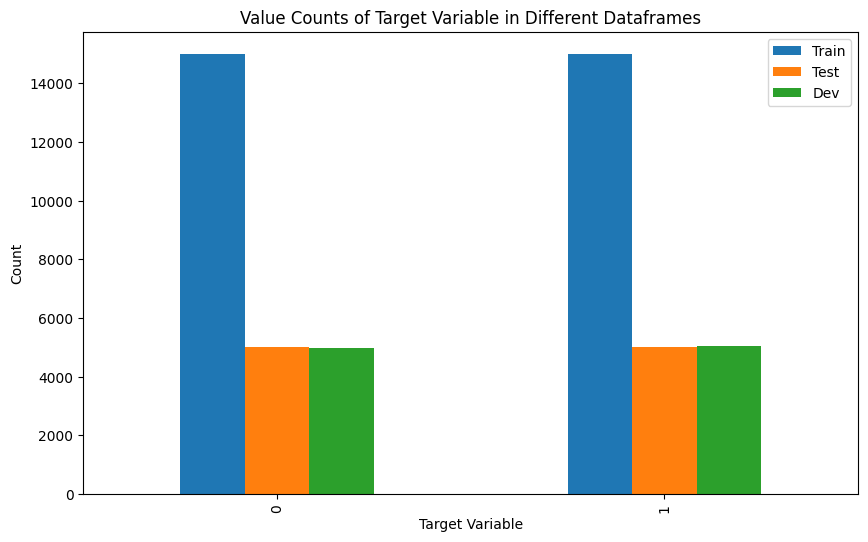

In [11]:

# Count the values of the ground truth (sentiments)
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()
dev_counts = y_dev.value_counts()


# Create a DataFrame with the counts
counts_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts, 'Dev': dev_counts})

# Plot the bar plot
counts_df.plot(kind='bar', figsize=(10, 6))
plt.title('Value Counts of Target Variable in Different Dataframes')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.show()


### PLOT THE SIZE OF THE REVIEW TEXTS FOR EACH SET

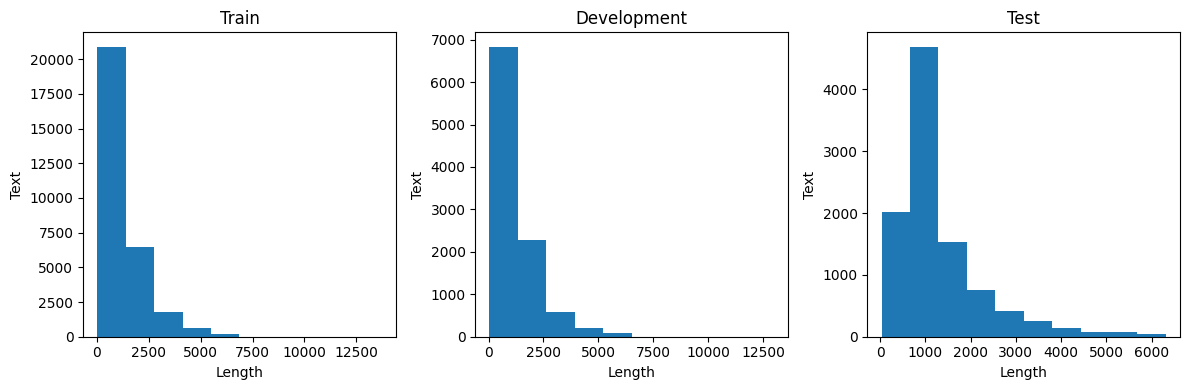

In [12]:
# Function to plot text lengths
def plot_text_lengths(ax, texts, title):
    text_lengths = [len(text) for text in texts]
    ax.hist(text_lengths)
    ax.set_xlabel('Length')
    ax.set_ylabel('Text')
    ax.set_title(title)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4))

# Plot for texts1
plot_text_lengths(ax1, X_train, 'Train')

# Plot for texts2
plot_text_lengths(ax2, X_dev, 'Development')

plot_text_lengths(ax3, X_test, 'Test')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## PREPROCESSING

* Replace non-word characters and numbers with empty string.
* Substitute multiple spaces with single space.
* Convert to lowercase.
* Remove stop words.
* Stemming with WordNetLemmatizer.

In [13]:
# Imports we need for preprocessing
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stemmer = WordNetLemmatizer()

# Import stop words for preprocessing
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/meizeus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/meizeus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/meizeus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
import re
def preprocess(contents):

    """
        Preprocesses a list of texts by removing non-word characters, single characters, extra spaces,
    converting to lowercase, splitting into words, lemmatizing, and reconstructing the documents.
    :param contents: A list of texts to be preprocessed
    :return: A Pandas Series containing preprocessed documents.
    """


    docs = []

    for doc in contents:
        # Convert the text to lowercase
        doc = doc.lower()

        # Delete all the non-word characters for the data frame
        document = re.sub(r'[^a-zA-Z\s]', '', str(doc))


        # Split the document based on whitespaces (--> List of words)
        word_list = document.split()

        word_list = [word for word in word_list if word not in (stop_words)]

        # Lemmatization
        word_list = [stemmer.lemmatize(word) for word in word_list]

        # Reconstruct the document by joining the words on each whitespace
        document = ' '.join(word_list)

        # Append all documents into a list 'docs'
        docs.append(document)
    return pd.Series(docs)

In [15]:
# Preprocess texts
X_train = preprocess(X_train)
X_dev = preprocess(X_dev)
X_test = preprocess(X_test)

### Example of a processed text

In [17]:
# Example of a preprocessed text
print(f'The non processed text:\n {df_train.reviews.iloc[10]}')
print('------------------------------------------------------------------------------------')
print('VS')
print('------------------------------------------------------------------------------------')
print(f'The processed text:\n {X_train[10]}')

The non processed text:
 If any show in the last ten years deserves a 10, it is this rare gem. It allows us to escape back to a time when things were simpler and more fun. Filled with heart and laughs, this show keeps you laughing through the three decades of difference. The furniture was ugly, the clothes were colorful, and the even the drugs were tolerable. The hair was feathered, the music was accompanied by roller-skates, and in the words of Merle Haggard, "a joint was a bad place to be". Take a trip back to the greatest time in American history. Fall in love with characters and the feel good essence of the small town where people were nicer to each other. This classic is on television as much as "Full House". Don't miss it, and always remember to "Shake your groove thing!!!"
------------------------------------------------------------------------------------
VS
------------------------------------------------------------------------------------
The processed text:
 show last ten y

## Baseline Model-1 (LogisticRegression)

* The dataset we are using in this notebook was used in exercise 9 part 3

* So, we know that TF-IDF with SVD provide the best results for the baseline model.



# TF-IDF Vectorization


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(ngram_range=(1, 3),
                             max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

print(X_train_tfidf.shape, type(X_train_tfidf))

(30000, 5000) <class 'scipy.sparse._csr.csr_matrix'>


## Dimensionality reduction via SVD method

In [18]:
# Reduce dimensionality using SVD 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_dev_svd = svd.transform(X_dev_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print(X_train_svd.shape, type(X_train_svd))

(30000, 1000) <class 'numpy.ndarray'>


### (Baseline 1) Build a Logistic Regression Baseline


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc
clf = LogisticRegression()
clf.fit(X_train_svd.tolist(), y_train)

# Validation set prediction
predictions = clf.predict(X_dev_svd.tolist())
print(f"\t\tClassification Report for developement set:\n\n {classification_report(y_dev, predictions)}")

# Test set prediction
predictions2 = clf.predict(X_test_svd.tolist())
print(f"\n\n\t\tClassification Report for testing set:\n\n {classification_report(y_test, predictions2)}")



		Classification Report for developement set:

               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4989
           1       0.88      0.90      0.89      5011

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



		Classification Report for testing set:

               precision    recall  f1-score   support

           0       0.89      0.88      0.88      4973
           1       0.88      0.89      0.89      5027

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Convert labels to 1-hot vectors(optinal for binary classification)

In [16]:
import tensorflow as tf

y_train_1_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_dev_1_hot = tf.keras.utils.to_categorical(y_dev, num_classes=2)


print(f"Y_train 1 hot: {y_train_1_hot}", "\n\n",f"Y_dev 1 hot:{y_dev_1_hot}")

2024-02-28 17:36:40.465005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 17:36:40.600471: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 17:36:41.129749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/meizeus/miniconda3/envs/tf_env/lib/
2024-02-28 17:36:41.131402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_

Y_train 1 hot: [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]] 

 Y_dev 1 hot:[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


### (Baseline 2) Build the MLP Model of exercise 9 Part 3

In [17]:
# Import libraries
# Import libraries
import keras
from keras.layers import InputLayer
from keras.layers import Activation, Dropout, Dense, Input,BatchNormalization, Flatten, Embedding
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


def create_MLP_model(input_dim, activation_dense_layers):
    """
    Create a deep feed forward network with Dense layers
    Add techniques such as dropout and Batch Normalization
    :param input_dum: integer for the dimension of the input layer)
    :param  activation_dense_layers: string, for the activation function
    :return: class keras.src.engine

    """
    mlp_model = Sequential()

    # Add InputLayer with specified input dimension
    mlp_model.add(InputLayer(input_shape=(input_dim,)))

    # First Layer
    mlp_model.add(Dense(128, activation='relu'))
    mlp_model.add(BatchNormalization())
    mlp_model.add(Dropout(0.4))
    # Second Layer
    mlp_model.add(Dense(512, activation='relu'))
    mlp_model.add(BatchNormalization())
    mlp_model.add(Dropout(0.5))
    # Third Layer
    mlp_model.add(Dense(128, activation='relu'))
    mlp_model.add(BatchNormalization())
    mlp_model.add(Dropout(0.4))
    # Output Layer
    mlp_model.add(Dense(1, activation='sigmoid'))


    return mlp_model


### Custom Keras callback for calculating F1, precision, recall at the end of each epoch

In [18]:
class Metrics(Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict_proba = self.model.predict(self.validation_data[0])
        val_predict = (val_predict_proba > 0.5).astype(int)  # Convert probabilities to classes

        val_targ = self.validation_data[1]

        _val_f1 = f1_score(val_targ, val_predict, average="binary")
        _val_recall = recall_score(val_targ, val_predict, average="binary")
        _val_precision = precision_score(val_targ, val_predict, average="binary")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %.3f — val_precision: %.3f — val_recall: %.3f" % (_val_f1, _val_precision, _val_recall))


In [23]:
from sklearn.metrics import f1_score, recall_score, precision_score

adam = Adam(learning_rate = 0.00004)

mlp = create_MLP_model(X_train_svd.shape[1],'relu')
mlp.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=["accuracy"]
    )

# Build the model and print the structure of our model before training
mlp.build(X_train_svd.shape[1])  # We need to build our model in order to print the structure
print(mlp.summary())

# Add an early stopping callback to stop the epochs when we catch the best validation loss
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for early stopping
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore best model weights when early stopping is triggered
)

# Callback to save the Keras model or model weights at some frequency.
MLP_checkpoint = ModelCheckpoint(
    'checkpoints/weights.hdf5',
    monitor='val_loss',
    mode='min',
    verbose=2,
    save_best_only=True,
    save_weights_only=True
    )

# Start our training
history = mlp.fit(
    X_train_svd,
    y_train,
    validation_data=(X_dev_svd, y_dev),
    batch_size=128,
    epochs=65,
    shuffle=True,
    callbacks=[early_stopping_callback]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               128128    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               

In [24]:
from keras import backend as K
K.clear_session()

In [25]:
# Evaluate in test set
evaluation = mlp.evaluate(X_test_svd, y_test)

print('Test Set Evaluation:')
print(f"The loss of the test set is:{evaluation[0]: .3f},\nThe accuracy of the test set is:{evaluation[1]*100: .3f}%")

# del mlp,clf # Save up memory

313/313 [==============================] - 0s 1ms/step - loss: 0.2722 - accuracy: 0.8889
Test Set Evaluation:
The loss of the test set is: 0.272,
The accuracy of the test set is: 88.890%


### Tokenize X_train, X_dev, X_test

In [16]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [17]:
import spacy
import string
import numpy as np
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner", "lemmatizer"])
from spacy.lang.en.stop_words import STOP_WORDS
nlp.add_pipe('sentencizer')


# Create a function that uses spacy to tokenize sentences and returns a nested list of tokenized sentences
def tokenize_data (data):
  """
    
    :param data: list of documents
    :return: nested list of the tokenized documents
    """
  data_tokenized = []
  for idx in tqdm(range(len(data))):
    doc = nlp(data[idx])
    tokens = []
    for sent in doc.sents:
      for tok in sent:
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or\
        tok.text.lower() in STOP_WORDS or tok.text in string.punctuation or\
          all(x in string.punctuation for x in tok.text) or is_number(tok.text):
          continue
        if tok.text.strip():
          tokens.append(tok.text.replace('"',"'").strip().lower())
    data_tokenized.append(tokens)
  return data_tokenized

X_train_tokenized = tokenize_data(X_train) 
X_dev_tokenized = tokenize_data(X_dev)
X_test_tokenized = tokenize_data(X_test)



100%|██████████| 10000/10000 [01:07<00:00, 148.71it/s]


### CHECK THE SEQUENCE LENGTH

* We are going to check the length of each review and drop the reviews that exceed the max sequence length that we will add to our RNN model.

In [18]:
mean_words = np.mean([len(x) for x in X_train_tokenized])
std_of_words = np.std([len(x) for x in X_train_tokenized])
               
# Get mean and std of sequence length on trainning set
print(f"Mean: {np.mean([len(x) for x in X_train_tokenized]): .2f}")
print(f"Std: {np.std([len(x) for x in X_train_tokenized]): .2f}")

Mean:  106.18
Std:  81.05


### KEEP THE REVIEWS WITH MAX LENGTH= mean_words * (2 * std_of_word_counts)

In [ ]:
print(f"{[len(x) for x in X_train_tokenized]}")

# Define a function that drops the rows not meeting the criteria
def estimate_max_seq_len(data_tokenized, targets, mean_w=mean_words, std_w=std_of_words):
    # Create a DataFrame to work with
    data = pd.DataFrame(columns=['data_tokenized', 'word_counts', 'targets'])

    # Assign the tokenized text to a column inside the dataframe
    data.data_tokenized =  data_tokenized
    # Assign the word counts for each row in a second column
    data.word_counts = [len(x) for x in data_tokenized]

    # Assign target variables
    data.targets = targets

    display(data.head())

    # Custom formula of estimating the MAX_words_Length
    MAX_words_length = mean_w + 2*std_w

    # Drop the rows not meeting the criteria
    data = data[data.word_counts <= MAX_words_length]

    return [' '.join(x) for x in data.data_tokenized], data.targets

X_train, y_train = estimate_max_seq_len(X_train_tokenized, y_train)
# X_dev = estimate_max_seq_len(X_dev_tokenized, y_dev)
# X_test = estimate_max_seq_len(X_test_tokenized, y_test)

### Convert text (sequence of words) to sequence of indexes and PAD the sequences
Using Keras's <a href='https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/'>TextVectorization layer </a>

In [17]:
import tensorflow as tf
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 266 # mean + (2 * std)
EMBEDDING_DIM = 300

vectorizer = tf.keras.layers.TextVectorization(max_tokens=MAX_WORDS, output_mode='int',
                                               ngrams=1, output_sequence_length=MAX_SEQUENCE_LENGTH)

vectorizer.adapt(X_train)

2024-02-28 17:36:41.951595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 17:36:41.981946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 17:36:41.982022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 17:36:41.982874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

#### Initialize embedding matrix with fasttext pre-trained embedings

In [18]:
# !pip install fasttext-wheel

import fasttext
import numpy as np
import fasttext.util


# Download model when running local
"""
First go to the directory of your choice(using command <cd> from terminal)
 and download the model via:
$ python

>>>pip install fasttext-wheel

>>>import fasttext
>>>import numpy as np
>>> import fasttext.util
>>>fasttext.util.download_model('en', if_exists='ignore') # English

Then uncomment the following code and load from the desired folder it was
downloaded!
"""
fasttext_model = fasttext.load_model('../../../../../big_files_DS/cc.en.300.bin')

# On laptop
# fasttext_model = fasttext.load_model('C:/Users/stath/Desktop/big_files_DS/cc.en.300.bin')


""" When in google collab we just need to download and load"""

# # Download model when in Google Collab
# fasttext.util.download_model('en', if_exists='ignore') # English
# fasttext_model =  fasttext.load_model('cc.en.300.bin')




embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

for w2idx, _word in enumerate(vectorizer.get_vocabulary()):
    # Skip PAD and UNK tokens
    if w2idx >= 2:
      embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)


In [19]:
# Example of the embeddings matrix
print(embedding_matrix[0,:])

del fasttext_model

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


* Class with functions that produce the training history for each epoch

In [20]:
from sklearn.metrics import f1_score, recall_score, precision_score
import os


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
          val_targ = np.argmax(val_targ, -1)


        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

#### Create a function that calculates both the acurracy and loss history for an RNN model 

In [21]:
def accuracy_loss_history(history):
    

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.xticks([x_tick for x_tick in range(0,len(history.history['accuracy'])+2,2)])
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper right')
    plt.xticks([x_tick for x_tick in range(0,len(history.history['accuracy'])+2,2)])
    plt.show()


### Create functions that initialize the Self Attention Mechanism given an RNN model 

In [22]:
class SelfAttention(tf.keras.layers.Layer):
  def __init__(self, mlp_layers=0, units=0, dropout_rate=0, return_attention=False, **kwargs):
    super(SelfAttention, self).__init__(**kwargs)
    self.mlp_layers = mlp_layers
    self.mlp_units = units
    self.return_attention = return_attention
    self.dropout_rate = dropout_rate
    self.attention_mlp = self.build_mlp()

  def build_mlp(self):
    mlp = tf.keras.Sequential()
    for i in range(self.mlp_layers):
      mlp.add(tf.keras.layers.Dense(self.mlp_units, activation='relu'))
      mlp.add(tf.keras.layers.Dropout(self.dropout_rate))
    mlp.add(tf.keras.layers.Dense(1))
    return mlp

  def call(self, x, mask=None):
    a = self.attention_mlp(x)
    a = tf.squeeze(a, axis=-1)

    if mask is not None:
      mask = tf.keras.backend.cast(mask, tf.keras.backend.floatx())
      a -= 100000.0 * (1.0 - mask)

    a = tf.keras.backend.expand_dims(tf.keras.backend.softmax(a, axis=-1))
    weighted_input = x * a
    result = tf.keras.backend.sum(weighted_input, axis=1)

    if self.return_attention:
      return [result, a]
    return result


###  Build BiLSTM + Linear self-attention with functional API
* The Keras functional API is a way to create models that are more flexible than the keras. Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs. The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers.

In [36]:
# %%capture
# !pip install numba

In [37]:
# Modules
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

LSTM_SIZE = 300
DENSE = 1000


inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)

# Add layers using functional API
x = vectorizer(inputs)
x = tf.keras.layers.Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                              input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False)(x)
x = tf.keras.layers.Dropout(0.33)(x)
# add a bidirrectional lstm layer with 0.33 variational (recurrent) dropout
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.33))(x)
x = tf.keras.layers.Dropout(0.33)(x)

# add a second bidirrectional lstm layer with 0.33 variational (recurrent) dropout
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.33))(x)
x = tf.keras.layers.Dropout(0.33)(x)

# # # add a third bidirrectional lstm layer with 0.33 variational (recurrent) dropout
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.33))(x)
# x = tf.keras.layers.Dropout(0.33)(x)

x, attention_weights = SelfAttention(mlp_layers=0, return_attention=True)(x)

x = tf.keras.layers.Dense(units=DENSE, activation='relu')(x)
x = tf.keras.layers.Dropout(0.33)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the model
stacked_bilstm_selfattn = tf.keras.Model(inputs=inputs, outputs=outputs)

model_for_attention = tf.keras.Model(inputs=inputs, outputs=attention_weights)

print(stacked_bilstm_selfattn.summary())


stacked_bilstm_selfattn.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Callback to save the Keras model or model weights at some frequency.
MLP_checkpoint = ModelCheckpoint(
    'checkpoints/weights3',
    monitor='val_loss',
    mode='min',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    save_format='tf'
)


history2 = stacked_bilstm_selfattn.fit(np.array(X_train), y_train,
              validation_data=(np.array(X_dev), y_dev),
              batch_size=256,
              epochs=10,
              shuffle=True,
              callbacks=[Metrics(valid_data=(np.array(X_dev), y_dev))])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 266)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 266, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 266, 300)          0         
                                                                 
 bidirectional (Bidirection  (None, 266, 600)          1442400   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 266, 600)          0     

c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 163s 521ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 954s 8s/step - loss: 0.4260 - accuracy: 0.8066 - val_loss: 0.3933 - val_accuracy: 0.8278 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 3/10


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 153s 488ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 952s 8s/step - loss: 0.4131 - accuracy: 0.8125 - val_loss: 0.4052 - val_accuracy: 0.8162 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 4/10


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 141s 450ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 946s 8s/step - loss: 0.4028 - accuracy: 0.8165 - val_loss: 0.3755 - val_accuracy: 0.8345 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 5/10


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 144s 459ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 944s 8s/step - loss: 0.3946 - accuracy: 0.8236 - val_loss: 0.3690 - val_accuracy: 0.8428 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 6/10


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 177s 564ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 980s 8s/step - loss: 0.3901 - accuracy: 0.8252 - val_loss: 0.3641 - val_accuracy: 0.8358 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 7/10


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 188s 600ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 993s 8s/step - loss: 0.3854 - accuracy: 0.8264 - val_loss: 0.3600 - val_accuracy: 0.8388 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 8/10


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 171s 548ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 979s 8s/step - loss: 0.3798 - accuracy: 0.8316 - val_loss: 0.3581 - val_accuracy: 0.8404 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 9/10


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 140s 448ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 950s 8s/step - loss: 0.3763 - accuracy: 0.8309 - val_loss: 0.3456 - val_accuracy: 0.8481 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 10/10


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 196s 625ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 998s 8s/step - loss: 0.3741 - accuracy: 0.8335 - val_loss: 0.3462 - val_accuracy: 0.8483 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Build BiLSTM + Linear self-attention with functional API -- Training History

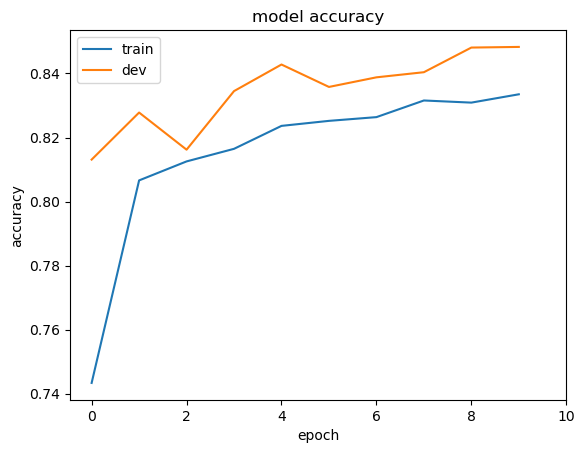

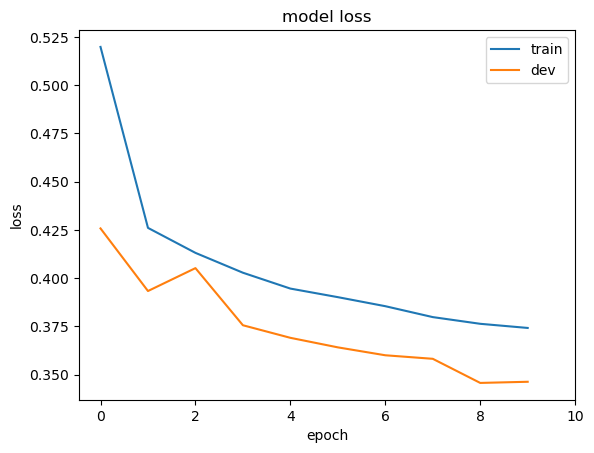

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
accuracy_loss_history(history2)

#### Build BiLSTM + Linear self-attention with functional API -- Classification report


In [39]:
predictions = stacked_bilstm_selfattn.predict(np.array(X_dev))
predictions = np.array([[1] if pred >= 0.5 else [0] for pred in predictions])
print(classification_report(y_dev, predictions))

313/313 [==============================] - 200s 638ms/step
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      4989
           1       0.85      0.84      0.85      5011

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### BiGRU + deep self-attention

In [40]:
GRU_SIZE = 300
DENSE = 1000

# create empty sequential model
biGRU_deep_selfatt = tf.keras.Sequential()
biGRU_deep_selfatt.add(tf.keras.layers.Input(shape=(1,), dtype=tf.string))
biGRU_deep_selfatt.add(vectorizer)
# add an embedding layer
biGRU_deep_selfatt.add(tf.keras.layers.Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))

# Use 0.33 dropout probabillity
biGRU_deep_selfatt.add(tf.keras.layers.Dropout(0.33))
# add a bidirectional gru layer
biGRU_deep_selfatt.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_SIZE, return_sequences=True)))

# Add a self-attention MLP (2 hidden layers)
biGRU_deep_selfatt.add(SelfAttention(mlp_layers=2, units=GRU_SIZE*2, dropout_rate=0.33 ))


# add an MLP output layer
biGRU_deep_selfatt.add(tf.keras.layers.Dense(units=DENSE, activation='relu' ))
biGRU_deep_selfatt.add(tf.keras.layers.Dropout(0.33))
biGRU_deep_selfatt.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(biGRU_deep_selfatt.summary())

biGRU_deep_selfatt.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=["accuracy"])


early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Callback to save the Keras model or model weights at some frequency.
MLP_checkpoint = ModelCheckpoint(
    'checkpoints/weights3',
    monitor='val_loss',
    mode='min',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    save_format='tf'
)


history3 = biGRU_deep_selfatt.fit(np.array(X_train), y_train,
              validation_data=(np.array(X_dev), y_dev),
              batch_size=256,
              epochs=20,
              shuffle=True,
              callbacks=[Metrics(valid_data=(np.array(X_dev), y_dev))])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 266)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 266, 300)          30000000  
                                                                 
 dropout_4 (Dropout)         (None, 266, 300)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 266, 600)          1083600   
 onal)                                                           
                                                                 
 self_attention_1 (SelfAtte  (None, 600)               721801    
 ntion)                                                          
                                                      

c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 44s 141ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 345s 3s/step - loss: 0.3249 - accuracy: 0.8623 - val_loss: 0.2973 - val_accuracy: 0.8753 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 3/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 44s 141ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 344s 3s/step - loss: 0.3095 - accuracy: 0.8707 - val_loss: 0.3049 - val_accuracy: 0.8673 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 4/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 44s 142ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 345s 3s/step - loss: 0.2915 - accuracy: 0.8801 - val_loss: 0.2685 - val_accuracy: 0.8853 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 5/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 50s 160ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 351s 3s/step - loss: 0.2845 - accuracy: 0.8822 - val_loss: 0.2660 - val_accuracy: 0.8895 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 6/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 60s 192ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 361s 3s/step - loss: 0.2726 - accuracy: 0.8873 - val_loss: 0.2622 - val_accuracy: 0.8931 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 7/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 84s 268ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 387s 3s/step - loss: 0.2662 - accuracy: 0.8898 - val_loss: 0.2564 - val_accuracy: 0.8961 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 8/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 82s 263ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 386s 3s/step - loss: 0.2580 - accuracy: 0.8941 - val_loss: 0.2569 - val_accuracy: 0.8942 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 9/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 82s 262ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 386s 3s/step - loss: 0.2531 - accuracy: 0.8969 - val_loss: 0.2594 - val_accuracy: 0.8931 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 10/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 82s 264ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 386s 3s/step - loss: 0.2438 - accuracy: 0.8983 - val_loss: 0.2488 - val_accuracy: 0.8987 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 11/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 84s 269ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 389s 3s/step - loss: 0.2411 - accuracy: 0.8992 - val_loss: 0.2456 - val_accuracy: 0.9011 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 12/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 65s 207ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 369s 3s/step - loss: 0.2329 - accuracy: 0.9054 - val_loss: 0.2493 - val_accuracy: 0.9018 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 13/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 70s 225ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 373s 3s/step - loss: 0.2212 - accuracy: 0.9100 - val_loss: 0.2531 - val_accuracy: 0.8987 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 14/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 70s 225ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 373s 3s/step - loss: 0.2165 - accuracy: 0.9129 - val_loss: 0.2534 - val_accuracy: 0.9015 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 15/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 52s 166ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 355s 3s/step - loss: 0.2033 - accuracy: 0.9179 - val_loss: 0.2458 - val_accuracy: 0.9017 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 16/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 51s 163ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 352s 3s/step - loss: 0.1987 - accuracy: 0.9213 - val_loss: 0.2492 - val_accuracy: 0.9003 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 17/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 45s 143ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 345s 3s/step - loss: 0.1954 - accuracy: 0.9216 - val_loss: 0.2520 - val_accuracy: 0.9019 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 18/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 45s 144ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 346s 3s/step - loss: 0.1871 - accuracy: 0.9245 - val_loss: 0.2515 - val_accuracy: 0.9058 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 19/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 56s 178ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 356s 3s/step - loss: 0.1797 - accuracy: 0.9269 - val_loss: 0.2477 - val_accuracy: 0.9068 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489
Epoch 20/20


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


313/313 [==============================] - 56s 179ms/step
 — val_f1: 0.332112 — val_precision: 0.248901 — val_recall: 0.498900
118/118 [==============================] - 357s 3s/step - loss: 0.1726 - accuracy: 0.9311 - val_loss: 0.2441 - val_accuracy: 0.9055 - val_f1: 0.3321 - val_recall: 0.4989 - val_precision: 0.2489


c:\Users\drago\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### BiGRU + deep self-attention -- Training History

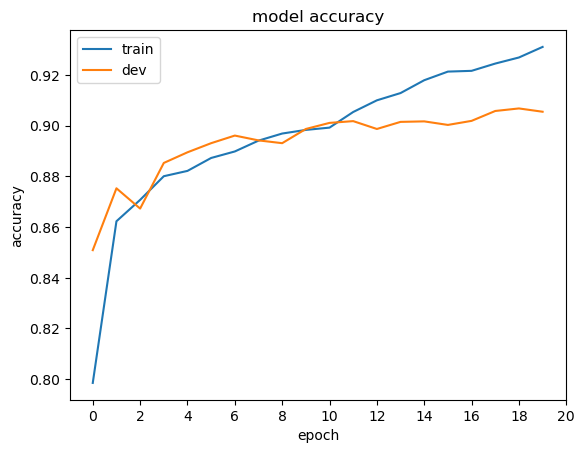

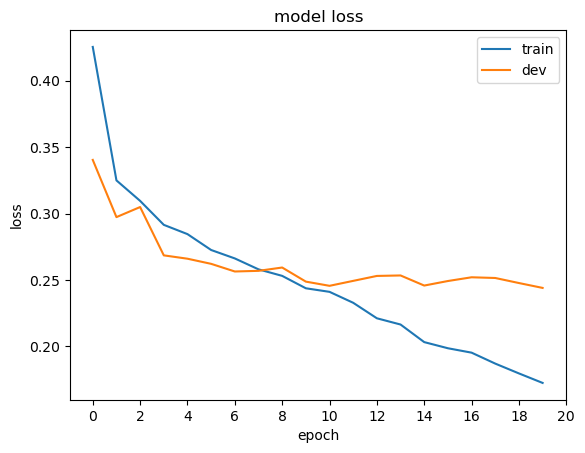

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
accuracy_loss_history(history3)

#### BiGRU + deep self-attention -- Classification Report

In [42]:
predictions = biGRU_deep_selfatt.predict(np.array(X_dev))
predictions = np.array([[1] if pred >= 0.5 else [0] for pred in predictions])

print(classification_report(y_dev, predictions))

313/313 [==============================] - 58s 184ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4989
           1       0.90      0.91      0.91      5011

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



# Results
* We will calculate precision, recall, F1, PR-auc scores first for each class and then macro average.

313/313 [==============================] - 145s 462ms/step


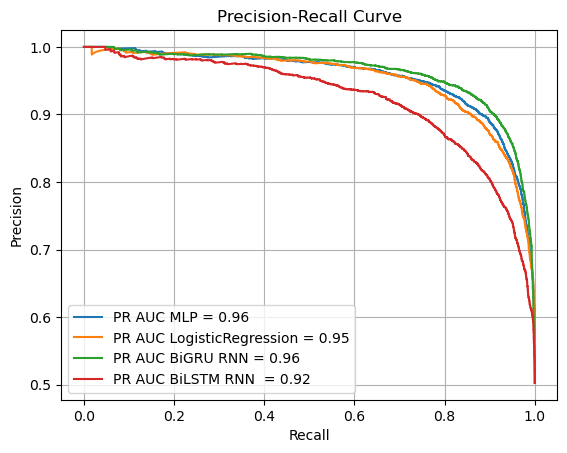

In [45]:
# Calculate model predictions (Multi Layer Perceptron Baseline-2)
y_pred = mlp.predict(X_test_svd)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Compute PR AUC
pr_auc = auc(recall, precision)

# Plot the PR curve for our model
plt.figure()
plt.plot(recall, precision, label='PR AUC MLP = %0.2f' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')


# Predict probabilities (Logistic Regression Baseline-1)
probs = clf.predict_proba(X_test_svd)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Calculate area under the curve (AUC) for PR curve
pr_auc = auc(recall, precision)

# Plot PR curve for baseline model
plt.plot(recall, precision, label=f'PR AUC LogisticRegression = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)



# Predict probabilities of X_test using BiDirectional GRU + deep Self attention
y_pred = biGRU_deep_selfatt.predict(np.array(X_test))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Compute PR AUC
pr_auc = auc(recall, precision)

# Plot the PR curve for our model
plt.plot(recall, precision, label='PR AUC BiGRU RNN = %0.2f' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')



# Predict probabilities of X_test using BiDirectional LSTM + linear Self attention
y_pred = stacked_bilstm_selfattn.predict(np.array(X_test))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Compute PR AUC
pr_auc = auc(recall, precision)

# Plot the PR curve for our model
plt.plot(recall, precision, label='PR AUC BiLSTM RNN  = %0.2f' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')




## Sum up Classification Reports + AUC Scores

In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, roc_auc_score

# Calculate predictions for clf
train_preds_clf = clf.predict_proba(X_train_svd)
train_preds_bin_clf = clf.predict(X_train_svd)

dev_preds_clf = clf.predict_proba(X_dev_svd)
dev_preds_bin_clf = clf.predict(X_dev_svd)

test_preds_clf = clf.predict_proba(X_test_svd)
test_preds_bin_clf = clf.predict(X_test_svd)




# Calculate predictions for BiGRU with deep self attention 
# predict train data
train_preds_biGRU = biGRU_deep_selfatt.predict(np.array(X_train))
train_preds_bin_biGRU = np.array([[1] if pred >= 0.5 else [0] for pred in train_preds_biGRU])

# predict dev data
dev_preds_biGRU = biGRU_deep_selfatt.predict(np.array(X_dev))
dev_preds_bin_biGRU = np.array([[1] if pred >= 0.5 else [0] for pred in dev_preds_biGRU])

# predict test data
test_preds_biGRU = biGRU_deep_selfatt.predict(np.array(X_test))
test_preds_bin_biGRU = np.array([[1] if pred >= 0.5 else [0] for pred in test_preds_biGRU])



# Calculate predictions for BiLSTM with linear self attention 
# predict train data
train_preds_biLSTM = stacked_bilstm_selfattn.predict(np.array(X_train))
train_preds_bin_biLSTM = np.array([[1] if pred >= 0.5 else [0] for pred in train_preds_biLSTM])

# predict dev data
dev_preds_biLSTM = stacked_bilstm_selfattn.predict(np.array(X_dev))
dev_preds_bin_biLSTM = np.array([[1] if pred >= 0.5 else [0] for pred in dev_preds_biLSTM])

# predict test data
test_preds_biLSTM = stacked_bilstm_selfattn.predict(np.array(X_test))
test_preds_bin_biLSTM = np.array([[1] if pred >= 0.5 else [0] for pred in test_preds_biLSTM])



313/313 [==============================] - 525s 2s/step


In [50]:
# Calculate predictions for MLP
# predict train data
train_preds_mlp = mlp.predict(X_train_svd)
train_preds_bin_mlp = np.array([[1] if pred >= 0.5 else [0] for pred in train_preds_mlp])

# predict dev data
dev_preds_mlp = mlp.predict(X_dev_svd)
dev_preds_bin_mlp = np.array([[1] if pred >= 0.5 else [0] for pred in dev_preds_mlp])

# predict test data
test_preds_mlp = mlp.predict(X_test_svd)
test_preds_bin_mlp = np.array([[1] if pred >= 0.5 else [0] for pred in test_preds_mlp])


313/313 [==============================] - 1s 2ms/step


In [54]:
from operator import pos
from sklearn.metrics import precision_recall_curve, average_precision_score

# Define a function to calculate metrics for each class including PR-AUC for MLP
def calculate_class_metrics_model(y_true, y_pred, y_probs):
    report = classification_report(y_true, y_pred, output_dict=True)
    # For class 1
    class_0_metrics = report['0']
    # For class 2
    class_1_metrics = report['1']

    # Calculate PR-AUC for each class
    precision, recall, _ = precision_recall_curve(y_true, y_probs, pos_label=1)
    pr_auc_class_1 = auc(recall, precision)

    # Its binary problem so 1-probability is the probability for class 0
    y_probs = 1-y_probs
    precision, recall, _ = precision_recall_curve(y_true, y_probs, pos_label=0)
    pr_auc_class_0 = auc(recall, precision)

    return class_0_metrics, class_1_metrics, pr_auc_class_0, pr_auc_class_1

# Define a function to calculate metrics for each class including PR-AUC for Logistic
def calculate_class_metrics_clf(y_true, y_pred, y_probs):
    report = classification_report(y_true, y_pred, output_dict=True)
    class_0_metrics = report['0']
    class_1_metrics = report['1']

    # Calculate PR-AUC for each class
    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1],pos_label=1)
    pr_auc_class_1 = auc(recall, precision)

    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 0],pos_label=0)
    pr_auc_class_0 = auc(recall, precision)

    return class_0_metrics, class_1_metrics, pr_auc_class_0, pr_auc_class_1



# Calculate class metrics for clf
class_0_metrics_train_clf, class_1_metrics_train_clf, pr_auc_0_train_clf, pr_auc_1_train_clf = calculate_class_metrics_clf(y_train, train_preds_bin_clf, train_preds_clf)
class_0_metrics_dev_clf, class_1_metrics_dev_clf, pr_auc_0_dev_clf, pr_auc_1_dev_clf = calculate_class_metrics_clf(y_dev, dev_preds_bin_clf, dev_preds_clf)
class_0_metrics_test_clf, class_1_metrics_test_clf, pr_auc_0_test_clf, pr_auc_1_test_clf = calculate_class_metrics_clf(y_test, test_preds_bin_clf, test_preds_clf)

# Calculate class metrics for MLP
class_0_metrics_train_mlp, class_1_metrics_train_mlp, pr_auc_0_train_mlp, pr_auc_1_train_mlp = calculate_class_metrics_model(y_train, train_preds_bin_mlp, train_preds_mlp)
class_0_metrics_dev_mlp, class_1_metrics_dev_mlp, pr_auc_0_dev_mlp, pr_auc_1_dev_mlp = calculate_class_metrics_model(y_dev, dev_preds_bin_mlp, dev_preds_mlp)
class_0_metrics_test_mlp, class_1_metrics_test_mlp, pr_auc_0_test_mlp, pr_auc_1_test_mlp = calculate_class_metrics_model(y_test, test_preds_bin_mlp,test_preds_mlp)

# Calculate class metrics for BiLSTM
class_0_metrics_train_biLSTM, class_1_metrics_train_biLSTM, pr_auc_0_train_biLSTM, pr_auc_1_train_biLSTM = calculate_class_metrics_model(y_train, train_preds_bin_biLSTM, train_preds_biLSTM)
class_0_metrics_dev_biLSTM, class_1_metrics_dev_biLSTM, pr_auc_0_dev_biLSTM, pr_auc_1_dev_biLSTM = calculate_class_metrics_model(y_dev, dev_preds_bin_biLSTM, dev_preds_biLSTM)
class_0_metrics_test_biLSTM, class_1_metrics_test_biLSTM, pr_auc_0_test_biLSTM, pr_auc_1_test_biLSTM = calculate_class_metrics_model(y_test, test_preds_bin_biLSTM,test_preds_biLSTM)


# Calculate class metrics for BiGRU
class_0_metrics_train_biGRU, class_1_metrics_train_biGRU, pr_auc_0_train_biGRU, pr_auc_1_train_biGRU = calculate_class_metrics_model(y_train, train_preds_bin_biGRU, train_preds_biGRU)
class_0_metrics_dev_biGRU, class_1_metrics_dev_biGRU, pr_auc_0_dev_biGRU, pr_auc_1_dev_biGRU = calculate_class_metrics_model(y_dev, dev_preds_bin_biGRU, dev_preds_biGRU)
class_0_metrics_test_biGRU, class_1_metrics_test_biGRU, pr_auc_0_test_biGRU, pr_auc_1_test_biGRU = calculate_class_metrics_model(y_test, test_preds_bin_biGRU,test_preds_biGRU)


# Create separate DataFrames for training, development, and test results for each class
train_class_metrics_df = pd.DataFrame({
    'Classifier': ['LR', 'MLP', 'biLSTM','biGRU'],
    'Class 0 Precision': [class_0_metrics_train_clf['precision'], class_0_metrics_train_mlp['precision'],class_0_metrics_train_biLSTM['precision'],class_0_metrics_train_biGRU['precision']],
    'Class 1 Precision': [class_1_metrics_train_clf['precision'], class_1_metrics_train_mlp['precision'],class_1_metrics_train_biLSTM['precision'],class_1_metrics_train_biGRU['precision']],
    'Class 0 Recall': [class_0_metrics_train_clf['recall'], class_0_metrics_train_mlp['recall'],class_0_metrics_train_biLSTM['recall'],class_0_metrics_train_biGRU['recall']],
    'Class 1 Recall': [class_1_metrics_train_clf['recall'], class_1_metrics_train_mlp['recall'],class_1_metrics_train_biLSTM['recall'],class_1_metrics_train_biGRU['recall']],
    'Class 0 F1-score': [class_0_metrics_train_clf['f1-score'], class_0_metrics_train_mlp['f1-score'],class_0_metrics_train_biLSTM['f1-score'],class_0_metrics_train_biGRU['f1-score']],
    'Class 1 F1-score': [class_1_metrics_train_clf['f1-score'], class_1_metrics_train_mlp['f1-score'],class_1_metrics_train_biLSTM['f1-score'],class_1_metrics_train_biGRU['f1-score']],
    'PR AUC Class 0': [pr_auc_0_train_clf, pr_auc_0_train_mlp,pr_auc_0_train_biLSTM,pr_auc_0_train_biGRU],
    'PR AUC Class 1': [pr_auc_1_train_clf, pr_auc_1_train_mlp,pr_auc_1_train_biLSTM,pr_auc_1_train_biGRU]
})

dev_class_metrics_df = pd.DataFrame({
    'Classifier': ['LR', 'MLP', 'biLSTM', 'biGRU'],
    'Class 0 Precision': [class_0_metrics_dev_clf['precision'], class_0_metrics_dev_mlp['precision'],class_0_metrics_dev_biLSTM['precision'],class_0_metrics_dev_biGRU['precision']],
    'Class 1 Precision': [class_1_metrics_dev_clf['precision'], class_1_metrics_dev_mlp['precision'],class_1_metrics_dev_biLSTM['precision'],class_1_metrics_dev_biGRU['precision']],
    'Class 0 Recall': [class_0_metrics_dev_clf['recall'], class_0_metrics_dev_mlp['recall'],class_0_metrics_dev_biLSTM['recall'],class_0_metrics_dev_biGRU['recall']],
    'Class 1 Recall': [class_1_metrics_dev_clf['recall'], class_1_metrics_dev_mlp['recall'],class_1_metrics_dev_biLSTM['recall'],class_1_metrics_dev_biGRU['recall']],
    'Class 0 F1-score': [class_0_metrics_dev_clf['f1-score'], class_0_metrics_dev_mlp['f1-score'],class_0_metrics_dev_biLSTM['f1-score'],class_0_metrics_dev_biGRU['f1-score']],
    'Class 1 F1-score': [class_1_metrics_dev_clf['f1-score'], class_1_metrics_dev_mlp['f1-score'],class_1_metrics_dev_biLSTM['f1-score'],class_1_metrics_dev_biGRU['f1-score']],
    'PR AUC Class 0': [pr_auc_0_dev_clf, pr_auc_0_dev_mlp,pr_auc_0_dev_biLSTM,pr_auc_0_dev_biGRU],
    'PR AUC Class 1': [pr_auc_1_dev_clf, pr_auc_1_dev_mlp,pr_auc_1_dev_biLSTM,pr_auc_1_dev_biGRU]
})

test_class_metrics_df = pd.DataFrame({
    'Classifier': ['LR', 'MLP', 'biLSTM', 'biGRU'],
    'Class 0 Precision': [class_0_metrics_test_clf['precision'], class_0_metrics_test_mlp['precision'], class_0_metrics_test_biLSTM['precision'],class_0_metrics_test_biGRU['precision']],
    'Class 1 Precision': [class_1_metrics_test_clf['precision'], class_1_metrics_test_mlp['precision'],class_1_metrics_test_biLSTM['precision'],class_1_metrics_test_biGRU['precision']],
    'Class 0 Recall': [class_0_metrics_test_clf['recall'], class_0_metrics_test_mlp['recall'],class_0_metrics_test_biLSTM['recall'],class_1_metrics_test_biGRU['recall']],
    'Class 1 Recall': [class_1_metrics_test_clf['recall'], class_1_metrics_test_mlp['recall'],class_1_metrics_test_biLSTM['recall'],class_1_metrics_test_biGRU['recall']],
    'Class 0 F1-score': [class_0_metrics_test_clf['f1-score'], class_0_metrics_test_mlp['f1-score'],class_0_metrics_test_biLSTM['f1-score'],class_1_metrics_test_biLSTM['f1-score']],
    'Class 1 F1-score': [class_1_metrics_test_clf['f1-score'], class_1_metrics_test_mlp['f1-score'],class_1_metrics_test_biLSTM['f1-score'],class_1_metrics_test_biLSTM['f1-score']],
    'PR AUC Class 0': [pr_auc_0_test_clf, pr_auc_0_test_mlp,pr_auc_0_test_biLSTM,pr_auc_0_test_biLSTM],
    'PR AUC Class 1': [pr_auc_1_test_clf, pr_auc_1_test_mlp,pr_auc_1_test_biLSTM,pr_auc_0_test_biLSTM]
})

from tabulate import tabulate

# Print training class metrics
print("Training Class Metrics:")
print(tabulate(train_class_metrics_df, headers='keys', tablefmt='psql'))

# Print development class metrics
print("\nDevelopment Class Metrics:")
print(tabulate(dev_class_metrics_df, headers='keys', tablefmt='psql'))

# Print test class metrics
print("\nTest Class Metrics:")
print(tabulate(test_class_metrics_df, headers='keys', tablefmt='psql'))


Training Class Metrics:
+----+--------------+---------------------+---------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+
|    | Classifier   |   Class 0 Precision |   Class 1 Precision |   Class 0 Recall |   Class 1 Recall |   Class 0 F1-score |   Class 1 F1-score |   PR AUC Class 0 |   PR AUC Class 1 |
|----+--------------+---------------------+---------------------+------------------+------------------+--------------------+--------------------+------------------+------------------|
|  0 | LR           |            0.900292 |            0.88501  |         0.882702 |         0.902293 |           0.89141  |           0.893568 |         0.960301 |         0.958453 |
|  1 | MLP          |            0.927662 |            0.95137  |         0.952654 |         0.925753 |           0.939992 |           0.938387 |         0.985251 |         0.985183 |
|  2 | biLSTM       |            0.854084 |            0

In [56]:
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, auc
import pandas as pd

def calculate_metrics(y_true, y_pred, y_probs):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    precision_auc, recall_auc, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall_auc, precision_auc)
    return precision, recall, f1, pr_auc

# Calculate class metrics for clf
precision_train_clf, recall_train_clf, f1_train_clf, pr_auc_train_clf = calculate_metrics(y_train, train_preds_bin_clf, train_preds_clf[:,1])
precision_dev_clf, recall_dev_clf, f1_dev_clf, pr_auc_dev_clf = calculate_metrics(y_dev, dev_preds_bin_clf, dev_preds_clf[:,1])
precision_test_clf, recall_test_clf, f1_test_clf, pr_auc_test_clf = calculate_metrics(y_test, test_preds_bin_clf, test_preds_clf[:,1])

# Calculate class metrics for model
precision_train_mlp, recall_train_mlp, f1_train_mlp, pr_auc_train_mlp = calculate_metrics(y_train, train_preds_bin_mlp, train_preds_mlp)
precision_dev_mlp, recall_dev_mlp, f1_dev_mlp, pr_auc_dev_mlp = calculate_metrics(y_dev, dev_preds_bin_mlp, dev_preds_mlp)
precision_test_mlp, recall_test_mlp, f1_test_mlp, pr_auc_test_mlp = calculate_metrics(y_test, test_preds_bin_mlp,test_preds_mlp)

# Calculate class metrics for biLSTM
precision_train_biLSTM, recall_train_biLSTM, f1_train_biLSTM, pr_auc_train_biLSTM = calculate_metrics(y_train, train_preds_bin_biLSTM, train_preds_biLSTM)
precision_dev_biLSTM, recall_dev_biLSTM, f1_dev_biLSTM, pr_auc_dev_biLSTM = calculate_metrics(y_dev, dev_preds_bin_biLSTM, dev_preds_biLSTM)
precision_test_biLSTM, recall_test_biLSTM, f1_test_biLSTM, pr_auc_test_biLSTM = calculate_metrics(y_test, test_preds_bin_biLSTM,test_preds_biLSTM)


# Calculate class metrics for biGRU
precision_train_biGRU, recall_train_biGRU, f1_train_biGRU, pr_auc_train_biGRU = calculate_metrics(y_train, train_preds_bin_biGRU, train_preds_biGRU)
precision_dev_biGRU, recall_dev_biGRU, f1_dev_biGRU, pr_auc_dev_biGRU = calculate_metrics(y_dev, dev_preds_bin_biGRU, dev_preds_biGRU)
precision_test_biGRU, recall_test_biGRU, f1_test_biGRU, pr_auc_test_biGRU = calculate_metrics(y_test, test_preds_bin_biGRU,test_preds_biGRU)




# Create separate DataFrames for training, development, and test results for each class
train_class_metrics_df = pd.DataFrame({
    'Classifier': ['LR', 'MLP', 'biLSTM', 'biGRU'],
    'Precision': [precision_train_clf, precision_train_mlp,precision_train_biLSTM,precision_train_biGRU],
    'Recall': [recall_train_clf, recall_train_mlp,recall_train_biLSTM,recall_train_biGRU],
    'F1': [f1_train_clf, f1_train_mlp,f1_train_biLSTM,f1_train_biGRU],
    'PR AUC': [pr_auc_train_clf, pr_auc_train_mlp,pr_auc_train_biLSTM,pr_auc_train_biGRU]
})

dev_class_metrics_df = pd.DataFrame({
    'Classifier': ['LR', 'MLP', 'biLSTM', 'biGRU'],
    'Precision': [precision_train_clf, precision_dev_mlp, precision_dev_biLSTM,precision_dev_biGRU],
    'Recall': [recall_dev_clf, recall_dev_mlp,recall_dev_biLSTM,recall_dev_biGRU],
    'F1': [f1_dev_clf, f1_dev_mlp,f1_dev_biLSTM,f1_dev_biGRU],
    'PR AUC': [pr_auc_dev_clf, pr_auc_dev_mlp,pr_auc_dev_biLSTM,pr_auc_dev_biGRU]
})

test_class_metrics_df = pd.DataFrame({
    'Classifier': ['LR', 'MLP', 'biLSTM', 'biGRU'],
    'Precision': [precision_test_clf, precision_test_mlp,precision_test_biLSTM,precision_test_biGRU],
    'Recall': [recall_test_clf, recall_test_mlp,recall_test_biLSTM,recall_test_biGRU],
    'F1': [f1_test_clf, f1_test_mlp,f1_test_biLSTM,f1_test_biGRU],
    'PR AUC': [pr_auc_test_clf, pr_auc_test_mlp,pr_auc_test_biLSTM,pr_auc_test_biGRU]
})

from tabulate import tabulate

# Print training class metrics
print("Training Class Metrics:")
print(tabulate(train_class_metrics_df, headers='keys', tablefmt='psql'))

# Print development class metrics
print("\nDevelopment Class Metrics:")
print(tabulate(dev_class_metrics_df, headers='keys', tablefmt='psql'))

# Print test class metrics
print("\nTest Class Metrics:")
print(tabulate(test_class_metrics_df, headers='keys', tablefmt='psql'))


Training Class Metrics:
+----+--------------+-------------+----------+----------+----------+
|    | Classifier   |   Precision |   Recall |       F1 |   PR AUC |
|----+--------------+-------------+----------+----------+----------|
|  0 | LR           |    0.892651 | 0.892497 | 0.892489 | 0.958453 |
|  1 | MLP          |    0.939516 | 0.939204 | 0.939189 | 0.985183 |
|  2 | biLSTM       |    0.856212 | 0.856201 | 0.856199 | 0.930473 |
|  3 | biGRU        |    0.962918 | 0.962899 | 0.9629   | 0.993177 |
+----+--------------+-------------+----------+----------+----------+

Development Class Metrics:
+----+--------------+-------------+----------+----------+----------+
|    | Classifier   |   Precision |   Recall |       F1 |   PR AUC |
|----+--------------+-------------+----------+----------+----------|
|  0 | LR           |    0.892651 | 0.885274 | 0.885278 | 0.953649 |
|  1 | MLP          |    0.888608 | 0.888236 | 0.888177 | 0.958003 |
|  2 | biLSTM       |    0.84834  | 0.848312 | 0.84

In [ ]:
# %%capture
# !pip install -U keras-tuner

## Tune BiGRU + deep self-attention Tuned via -- Keras Tuner



The parameter space here is :

* embedding_dropout: Dropout rate after the embedding layer.
* gru_units: Number of units in the Bidirectional GRU layer.
* gru_dropout: Dropout rate after the Bidirectional GRU layer.
* num_attention_layers: Number of self-attention layers.
* attention_units: Number of units in the self-attention mechanism.
* attention_dropout: Dropout rate in the self-attention mechanism.
* dense_activation: Activation function in the dense layer before the output layer.
* dense_dropout: Dropout rate before the output layer.
* learning_rate: Learning rate for the Adam optimizer.


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, GRU, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
 
GRU_SIZE = 300
DENSE = 1000

def build_gru_model(hp):
    model = tf.keras.Sequential()

    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorizer)
    model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
    
    model.add(Dropout(hp.Float('embedding_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Bidirectional(GRU(hp.Int('gru_units_1', min_value=128, max_value=1152, step=128), return_sequences=True)))
    model.add(Dropout(hp.Float('gru_dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # We can add one more layer(but gpu dedicated memory caps out)
    # model.add(Bidirectional(GRU(hp.Int('gru_units_2', min_value=128, max_value=1000, step=64), return_sequences=True)))
    
    model.add(SelfAttention(mlp_layers=hp.Choice('num_attention_layers', values=[1, 2, 3]),
                             units=hp.Int('attention_units', min_value=128, max_value=1152, step=128),
                             dropout_rate=hp.Float('attention_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=DENSE, activation=hp.Choice('dense_activation', values=['relu', 'tanh'])))
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4])),
                  metrics=["accuracy"])

    return model


tuner = kt.RandomSearch(build_gru_model,
                        objective=kt.Objective('val_accuracy', direction='max'),
                        max_trials=5,
                        directory="KT_dir",
                        project_name='biGRU_tuning') # Make dir KT_dir/biGRU_tuning that holds the model evaluated during tuning

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

MLP_checkpoint = ModelCheckpoint(
    'checkpoints/weights3',
    monitor='val_loss',
    mode='min',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    save_format='tf'
)

tuner.search(np.array(X_train), y_train,
             validation_data=(np.array(X_dev), y_dev),
             batch_size=256,
             epochs=20,
             shuffle=True,
             callbacks=[early_stopping_callback, MLP_checkpoint])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] # num_trials=1 retrieves the single best hyperparameters.
print(f"Optimal Hyperparameters: {best_hps}")


Reloading Tuner from KT_dir/biGRU_tuning/tuner0.json
Optimal Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7ff86013fd60>


* Extract the first model from the list of model, which is apparently the best model because this list is sorted!

In [24]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 266)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 266, 300)          30000000  
                                                                 
 dropout (Dropout)           (None, 266, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 266, 512)         857088    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 266, 512)          0         
                                                                 
 self_attention (SelfAttenti  (None, 512)              5

* Classification Report for the best model with tuned parameters in developement set

In [25]:
from sklearn.metrics import classification_report

predictions_dev = best_model.predict(np.array(X_dev))
predictions_dev = np.array([[1] if pred >= 0.5 else [0] for pred in predictions_dev])

print(classification_report(y_dev, predictions_dev))

  2/313 [..............................] - ETA: 18s 

2024-02-28 17:37:23.208125: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800


313/313 [==============================] - 15s 43ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4960
           1       0.90      0.90      0.90      5040

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



* Classification Report for the best model with tuned parameters in testing set

In [27]:
predictions_test = best_model.predict(np.array(X_test))
predictions_test = np.array([[1] if pred >= 0.5 else [0] for pred in predictions_test])

print(classification_report(y_test, predictions_test))


313/313 [==============================] - 13s 41ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5008
           1       0.91      0.90      0.90      4992

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

